In [1]:
import os
from pathlib import Path
import subprocess
from langchain.prompts import PromptTemplate
from lang_funcs import ( create_llm_openai,create_llm_agent,read_toml )

config = read_toml("./config.toml")

# python
languge_dependent_file = "requirements.txt"

llm = create_llm_openai( 
                         model=config["openai"]["model"],
                         apikey=config["openai"]["api_key"],
                         apibase=config["openai"]["url"])

# 定义命令和参数
command = ["trivy", "fs", "-f", "json", "-o", "results.json", "."]
try:
    # 执行命令并等待其完成
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    print("Command executing .......")
    # 打印命令的标准输出和标准错误
    print("stdout:", result.stdout)
    print("stderr:", result.stderr)
    print("Command executed successfully.")

except subprocess.CalledProcessError as e:
    # 命令执行失败时处理错误
    print("An error occurred while executing the command.")
    print("stderr:", e.stderr)

with open("results.json", 'r', encoding='utf-8') as file:
    vuln_file = file.read()

with open(languge_dependent_file, 'r', encoding='utf-8') as file:
    dep_file = file.read()

# 定义模板
pr_template = """
请对比组件内容和组件漏洞清单,生产一个Github格式的PR:

组件漏洞清单如下:
{vuln_file}

python 依赖文件 requirements.txt文件 组件内容如下:
{dep_file}


没有漏洞输出 None.

如果有漏洞则输出如下参考格式:
## Changes

Bumps xxx from 0.19.0 to 0.21.0.

Bumps xxxx from 0.10.0 to 0.11.0.

## References
- [CVE-2023-45288](https://avd.aquasec.com/nvd/cve-2023-45288)
- [CVE-2024-24786](https://avd.aquasec.com/nvd/cve-2024-24786)

"""

# 定义 PromptTemplate
prompt = PromptTemplate(
    input_variables=["vuln_file", "dep_file"],
    template=pr_template
)

# 生成描述
pr_description = prompt.format(
    vuln_file=vuln_file,
    dep_file=dep_file
)

# 使用 LLM 生成输出
output = llm.predict(pr_description)

# 打印生成的 Pull Request 描述
print(output)

pr_code_template = """
请根据组件漏洞清单,修复requirements.txt中的组件版本:

组件漏洞清单如下:
{vuln_file}

requirements.txt:
{dep_file}

输出与requirements.txt格式保持一致,并标注做了修改
"""


code_prompt = PromptTemplate(
    input_variables=["vuln_file", "dep_file"],
    template=pr_code_template
)

# 生成描述
pr_code_description = code_prompt.format(
    vuln_file=vuln_file,
    dep_file=dep_file
)



output = llm.predict(pr_code_description)
print(output)

Command executing .......
stdout: 
stderr: 2024-05-23T15:37:35+08:00	INFO	Vulnerability scanning is enabled
2024-05-23T15:37:35+08:00	INFO	Secret scanning is enabled
2024-05-23T15:37:35+08:00	INFO	If your scanning is slow, please try '--scanners vuln' to disable secret scanning
2024-05-23T15:37:35+08:00	INFO	Please see also https://aquasecurity.github.io/trivy/v0.51/docs/scanner/secret/#recommendation for faster secret detection
2024-05-23T15:37:44+08:00	INFO	Number of language-specific files	num=1
2024-05-23T15:37:44+08:00	INFO	[pip] Detecting vulnerabilities...

Command executed successfully.


/Users/yoyofx/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


```markdown
## Changes

Bumps SQLAlchemy from 2.0.0
langchain
langchain-community
langchain-core                 
langchain-openai



client=<openai.resources.chat.completions.Completions object at 0x137dc6290> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x137dcded0> model_name='gpt-4' temperature=0.8 openai_api_key=SecretStr('**********') openai_proxy='' azure_endpoint='https://s2oai.openai.azure.com/' deployment_name='vision' openai_api_version='2024-05-01-preview' openai_api_type='azure'


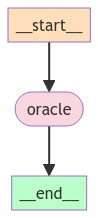

[HumanMessage(content='What is 1 + 1?', id='d5e20157-a5c0-49fa-93cb-233e60e4d867'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-17ac65e1-3648-4399-b61e-1c4161eb7cb0-0')]

In [2]:
import os
from pathlib import Path
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph
from IPython.display import Image, display
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from langchain.prompts import PromptTemplate
from lang_funcs import ( create_llm_openai,create_llm_agent,read_toml )

config = read_toml("./config.toml")

model = create_llm_openai(model=config["openai"]["model"],
                         apikey=config["openai"]["api_key"],
                         apibase=config["openai"]["url"])

print(model)
graph = MessageGraph()

graph.add_node("oracle", model)
graph.add_edge("oracle", END)

graph.set_entry_point("oracle")

runnable = graph.compile()
display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))

runnable.invoke(HumanMessage("What is 1 + 1?"))








In [1]:
from typing import Literal

@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number

model_with_tools = model.bind_tools(tools=[multiply])

graph = MessageGraph()

graph.add_node("oracle", model_with_tools)

tool_node = ToolNode([multiply])
graph.add_node("multiply", tool_node)

graph.add_edge("multiply", END)


def router(state: list[BaseMessage]) -> Literal["multiply", "__end__"]:
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return END


graph.add_conditional_edges("oracle", router)

graph.set_entry_point("oracle")
runnable = graph.compile()

# runnable.invoke(HumanMessage("What is 123 * 456?"))
# runnable.invoke(HumanMessage("你叫什么名子?"))


display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))

NameError: name 'tool' is not defined